In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')
methods = ['VG', 'COW', 'LNAM']

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

## Shift Analysis

In [3]:
with open('/srv/scratch/z5297792/Sample/eddy_sub_data.pkl', 'rb') as file:
    eddy_sub_data = pickle.load(file)
the_frontier_eddies = list(eddy_sub_data.keys())

In [4]:
depth_data_dic = {}
for eddy in the_frontier_eddies:
    depth_data_dic[eddy] = {}
    for method in methods:
        
        depth_dfs = []
        for t in range(30):
            for col in ['x', 'y', 'TD']:
                depth_data = eddy_sub_data[eddy][f'T{t}'][method]['depth_data'][['Depth', col]]
                depth_data.columns = ['Depth', f'{col}{t}']
                depth_dfs.append(depth_data.set_index('Depth'))
        depth_df = pd.concat(depth_dfs, axis=1).sort_index(ascending=False)
        depth_data_dic[eddy][method] = depth_df

rho_data_dic = {}
for eddy in the_frontier_eddies:
    rho_data_dic[eddy] ={}
    for method in methods:
        rho_dfs = []
        for t in range(30):
            for col in ['x', 'y', 'TD']:
                rho_data = eddy_sub_data[eddy][f'T{t}'][method]['rho_data'][['rho', col]]
                rho_data.columns = ['rho', f'{col}{t}']
                rho_dfs.append(rho_data.set_index('rho'))
        rho_df = pd.concat(rho_dfs, axis=1).sort_index()
        rho_data_dic[eddy][method] = rho_df


In [5]:
depth_data_dic[eddy][method]

,x0,y0,TD0,x1,y1,TD1,x2,y2,TD2,x3,...,TD26,x27,y27,TD27,x28,y28,TD28,x29,y29,TD29
Depth,,,,,,,,,,,,,,,,,,,,,
-0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
-10.0,2550.705729,-449.294271,2589.973949,3000.000000,449.294271,3033.457655,3000.00000,6000.000000,6708.203932,0.000000,...,15573.482954,-6000.000000,0.000000,6000.000000,-5550.705729,0.0,5550.705729,-6000.000000,3000.0,6708.203932
-20.0,3000.000000,1658.500034,3427.918080,4658.500034,3317.000069,5718.750915,6000.00000,10658.500034,12231.255985,-6000.000000,...,20553.749624,-9000.000000,0.000000,9000.000000,-6000.000000,0.0,6000.000000,-4658.500034,0.0,4658.500034
-30.0,3000.000000,3000.000000,4242.640687,6000.000000,6000.000000,8485.281374,6000.00000,14822.790707,15991.095157,-3177.209293,...,21840.329668,-9000.000000,0.000000,9000.000000,-6000.000000,0.0,6000.000000,-6000.000000,0.0,6000.000000
-40.0,3000.000000,3000.000000,4242.640687,6000.000000,9000.000000,10816.653826,5711.33731,14711.337310,15781.090562,-6288.662690,...,24738.633754,-12000.000000,0.000000,12000.000000,-6000.000000,0.0,6000.000000,-6000.000000,0.0,6000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1090.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12196.200570,5135.528143,8567.764072,9989.005481,NaN,NaN,NaN,NaN,NaN,NaN
-1100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12233.649529,5357.766949,8678.883475,10199.445330,NaN,NaN,NaN,NaN,NaN,NaN
-1110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12276.014357,5580.005755,8790.002877,10411.561593,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
rho_data_dic[eddy][method]

,x0,y0,TD0,x1,y1,TD1,x2,y2,TD2,x3,...,TD26,x27,y27,TD27,x28,y28,TD28,x29,y29,TD29
rho,,,,,,,,,,,,,,,,,,,,,
24.7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.8,3000.0,0.000000,3000.000000,3000.000000,124.774813,3002.593671,3436.340892,6436.340892,7296.226614,-1083.046076,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.9,3000.0,3000.000000,4242.640687,6000.000000,6499.326095,8845.407830,6000.000000,15000.000000,16155.494421,-3952.380555,...,3722.262059,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
25.0,3000.0,4244.091814,5197.337331,4973.052957,7973.052957,9396.852088,3000.000000,12000.000000,12369.316877,-10332.742586,...,21840.329668,-9000.000000,0.000000,9000.000000,-6000.0,0.0,6000.0,-6000.0,3000.0,6708.203932
25.1,3000.0,6000.000000,6708.203932,3414.412894,6828.825787,7634.859333,3000.000000,12000.000000,12369.316877,-11083.560837,...,24738.633754,-12000.000000,0.000000,12000.000000,-6000.0,0.0,6000.0,-6000.0,0.0,6000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12198.839841,5154.596435,8577.298218,10006.993011,NaN,NaN,NaN,NaN,NaN,NaN
32.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12275.007863,5577.731326,8788.865663,10409.382613,NaN,NaN,NaN,NaN,NaN,NaN
32.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12368.784805,6000.000000,9000.000000,10816.653826,NaN,NaN,NaN,NaN,NaN,NaN


## Optimal 3D Shift Computation

### Solve the Problem

$$
\huge x' = x\cos\theta - y\sin\theta + a
$$
$$
\huge y' = x\sin\theta + y\cos\theta + b
$$
\
$$
\begin{aligned}
\huge R(a, b, \theta) & \huge = \sum_i \left[x_i'(t_1) - x_i(t_2)\right]^2 + \left[y_i'(t_1) - y_i(t_2)\right]^2 \\
                      & \huge = \sum_i \left[x_i(t_1)\cos\theta - y_i(t_1)\sin\theta + a - x_i(t_2) \right]^2 + \left[x_i(t_1)\sin\theta + y_i(t_1)\cos\theta + b - y_i(t_2)\right]^2
\end{aligned}
$$

In [7]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg) 
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))

def depth_shift_finder(depth_df):

    best_shift_3D_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'Error'])
    for t in range(30):
        # if t != 29:
            # Sample data 
            x_t1 = depth_df['x'+str(t)]/1000  # x-coordinates at t1
            y_t1 = depth_df['y'+str(t)]/1000   # y-coordinates at t1
            x_t2 = depth_df['x14']/1000  # x-coordinates at t2
            y_t2 = depth_df['y14']/1000   # y-coordinates at t2
        
            # Objective function
            def R(params):
                a, b, theta = params
                cos_theta = np.cos(theta)
                sin_theta = np.sin(theta)
                term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
                term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
                return np.sum(term1 + term2)
            
            # Initial guess for a, b, theta
            initial_guess = [0, 0, 0]
            
            # Optimize
            result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
            a_opt, b_opt, theta_opt = result.x
            error = R((a_opt, b_opt, theta_opt))
            theta_opt = np.rad2deg(theta_opt)
            
            best_shift_3D_df.loc[len(best_shift_3D_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'Error': error}
        # else:
        #     best_shift_3D_df.loc[len(best_shift_3D_df)] = {'Day': t, 'theta': 0, 'i': 0, 'j': 0, 'rmse': 0}
        
    best_shift_3D_df.set_index('Day', inplace=True)
    
    return best_shift_3D_df

def rho_shift_finder(rho_df):

    best_shift_3D_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'Error'])
    for t in range(30):
        # if t != 29:
            # Sample data 
            x_t1 = rho_df['x'+str(t)]/1000  # x-coordinates at t1
            y_t1 = rho_df['y'+str(t)]/1000   # y-coordinates at t1
            x_t2 = rho_df['x14']/1000  # x-coordinates at t2
            y_t2 = rho_df['y14']/1000   # y-coordinates at t2
        
            # Objective function
            def R(params):
                a, b, theta = params
                cos_theta = np.cos(theta)
                sin_theta = np.sin(theta)
                term1 = (x_t1 * cos_theta - y_t1 * sin_theta + a - x_t2)**2
                term2 = (x_t1 * sin_theta + y_t1 * cos_theta + b - y_t2)**2
                return np.sum(term1 + term2)
            
            # Initial guess for a, b, theta
            initial_guess = [0, 0, 0]
            
            # Optimize
            result = minimize(R, initial_guess, bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, 2*np.pi)])
            a_opt, b_opt, theta_opt = result.x
            error = R((a_opt, b_opt, theta_opt))
            theta_opt = np.rad2deg(theta_opt)
            
            best_shift_3D_df.loc[len(best_shift_3D_df)] = {'Day': t, 'theta': theta_opt, 'i': a_opt, 'j': b_opt, 'Error': error}
        # else:
        #     best_shift_3D_df.loc[len(best_shift_3D_df)] = {'Day': t, 'theta': 0, 'i': 0, 'j': 0, 'rmse': 0}
        
    best_shift_3D_df.set_index('Day', inplace=True)
    
    return best_shift_3D_df


In [8]:
# Find best shifts

best_depth_shift_dic = {}
for eddy in the_frontier_eddies:
    best_depth_shift_dic[eddy] = {}
    for method in methods:
        depth_df = depth_data_dic[eddy][method]
        best_depth_shift_df = depth_shift_finder(depth_df)
        best_depth_shift_dic[eddy][method] = best_depth_shift_df

best_depth_shift_dic[eddy][method]

,theta,i,j,Error
Day,,,,
0,75.999635,-8.727018,-9.148951,1633.288315
1,82.540101,-7.883128,-8.339514,2191.128601
2,62.823273,-4.058440,-13.919870,1821.778696
3,13.247110,-9.439997,-0.869949,2252.113538
4,60.406828,-16.441302,-5.854480,2716.371398
5,0.000000,-8.113306,-7.044468,230.207264
6,0.000000,1.304471,9.385566,2771.471137
7,0.000000,-16.418297,1.590108,2523.183048
8,0.000000,-15.609134,-0.868192,1913.251178


In [9]:
best_rho_shift_dic = {}
for eddy in the_frontier_eddies:
    best_rho_shift_dic[eddy] = {}
    for method in methods:
        rho_df = rho_data_dic[eddy][method]
        best_rho_shift_df = rho_shift_finder(rho_df)
        best_rho_shift_dic[eddy][method] = best_rho_shift_df

best_rho_shift_dic[eddy][method]

,theta,i,j,Error
Day,,,,
0,80.416778,-6.920169,-10.172708,1822.406030
1,92.354383,-5.367412,-8.633196,2669.218192
2,67.391414,-2.380502,-14.050776,2033.784135
3,21.539719,-8.384649,-1.431330,2450.865339
4,360.000000,-19.027669,-6.605786,3307.178644
5,17.704667,-6.662852,-5.788215,191.322760
6,0.000000,2.687345,7.342618,3132.663053
7,0.000000,-16.343756,-0.683858,2404.401031
8,0.000000,-15.969644,-2.765723,1721.803557


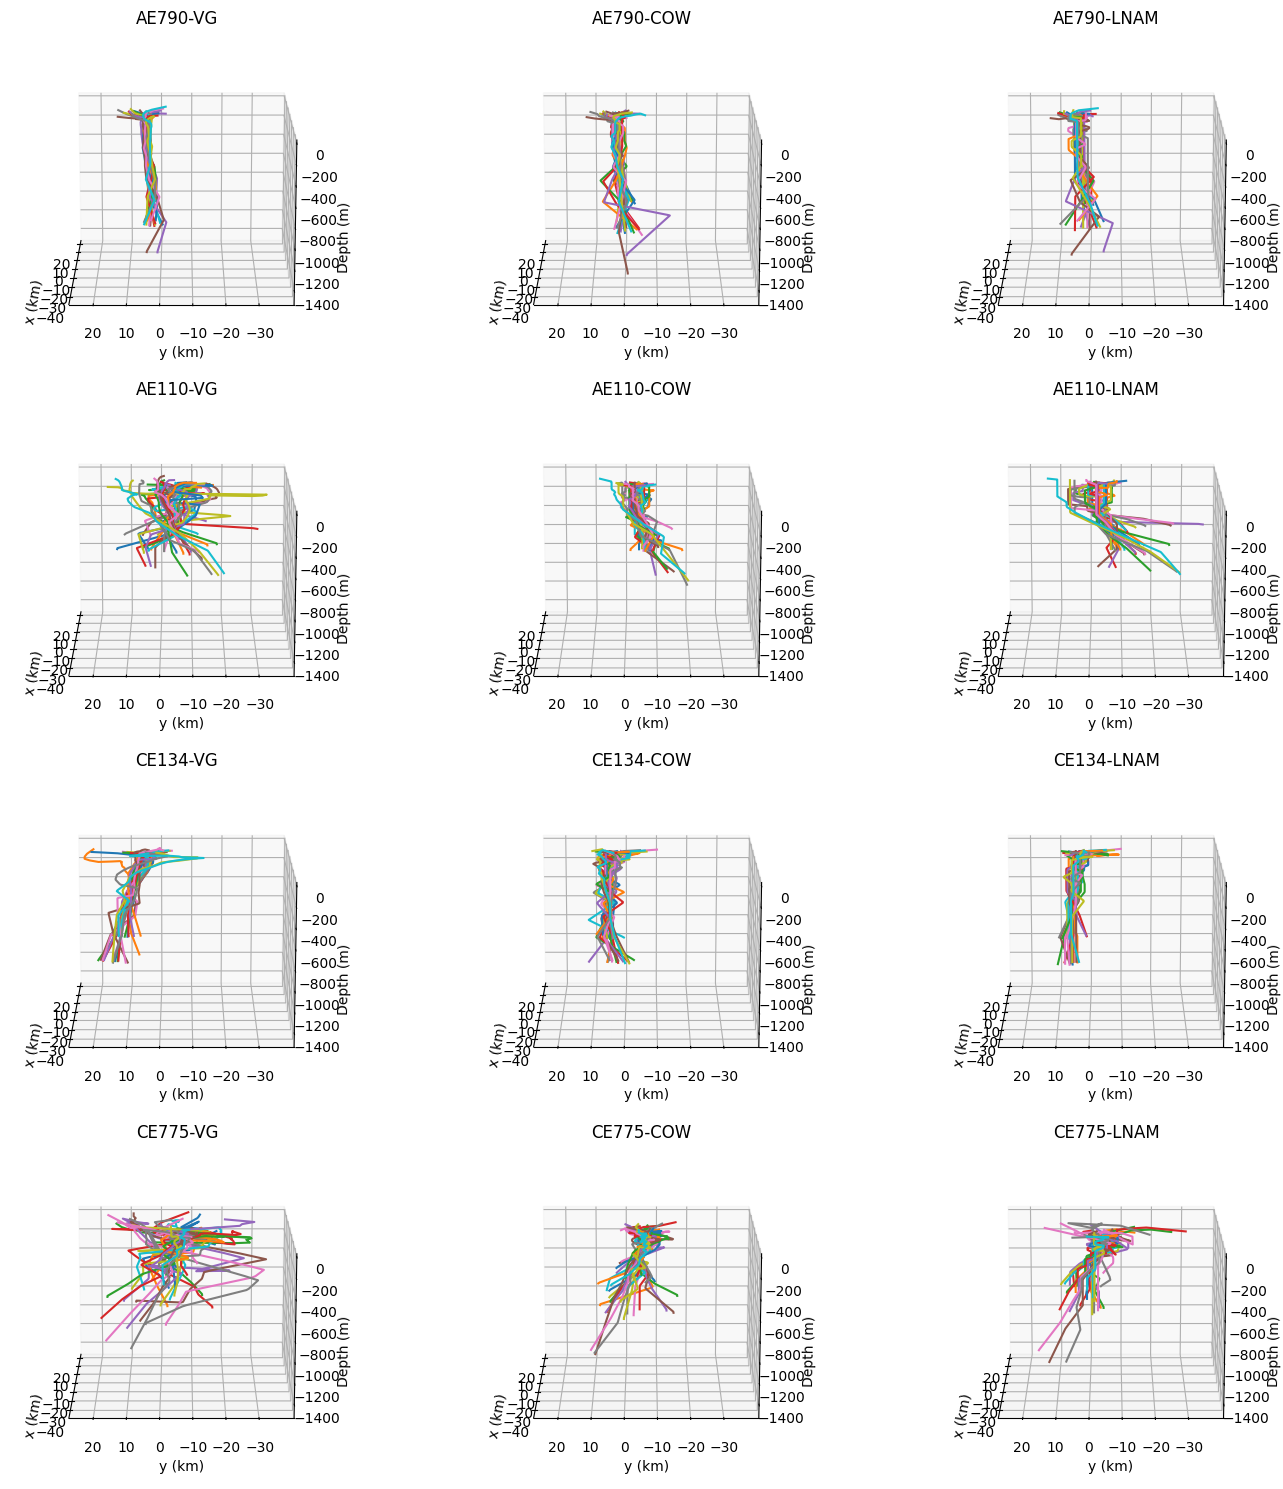

In [10]:
fig, axs = plt.subplots(4, 3, subplot_kw={'projection': '3d'}, figsize=(15,15))

for r, eddy in enumerate(the_frontier_eddies):

    for c, method in enumerate(methods):

        for t in range(30):
            theta = best_depth_shift_dic[eddy][method].loc[t]['theta']
            i = best_depth_shift_dic[eddy][method].loc[t]['i']
            j = best_depth_shift_dic[eddy][method].loc[t]['j']

            x = depth_data_dic[eddy][method]['x'+str(t)] / 1000
            y = depth_data_dic[eddy][method]['y'+str(t)] / 1000
            z = depth_data_dic[eddy][method].index

            points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
            x_shifted = points_rotated[:, 0] + i
            y_shifted = points_rotated[:, 1] + j

            axs[r, c].plot(x_shifted, y_shifted, z)
            axs[r, c].view_init(15, 180)
            axs[r, c].set_title('AE'+str(extract_number(eddy))+'-'+ method if r < 2 else 'CE'+str(extract_number(eddy))+'-'+ method)
            axs[r, c].set_xlabel('x (km)')
            axs[r, c].set_ylabel('y (km)')
            axs[r, c].set_zlabel('Depth (m)')

xmax, xmin, ymin, ymax, zmin = 0, 0, 0, 0, 0
for ax in axs.flat:
    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()
    z1, z2 = ax.get_zlim()

    xmax = max(xmax, x2)
    xmin = min(xmin, x1)
    ymax = max(ymax, y2)
    ymin = min(ymin, y1)
    zmin = min(zmin, z1)

xmax_3Ddep, xmin_3Ddep, ymin_3Ddep, ymax_3Ddep, zmin_3Ddep = xmax, xmin, ymin, ymax, zmin

for ax in axs.flat:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, 0)
    
plt.tight_layout()
plt.show()

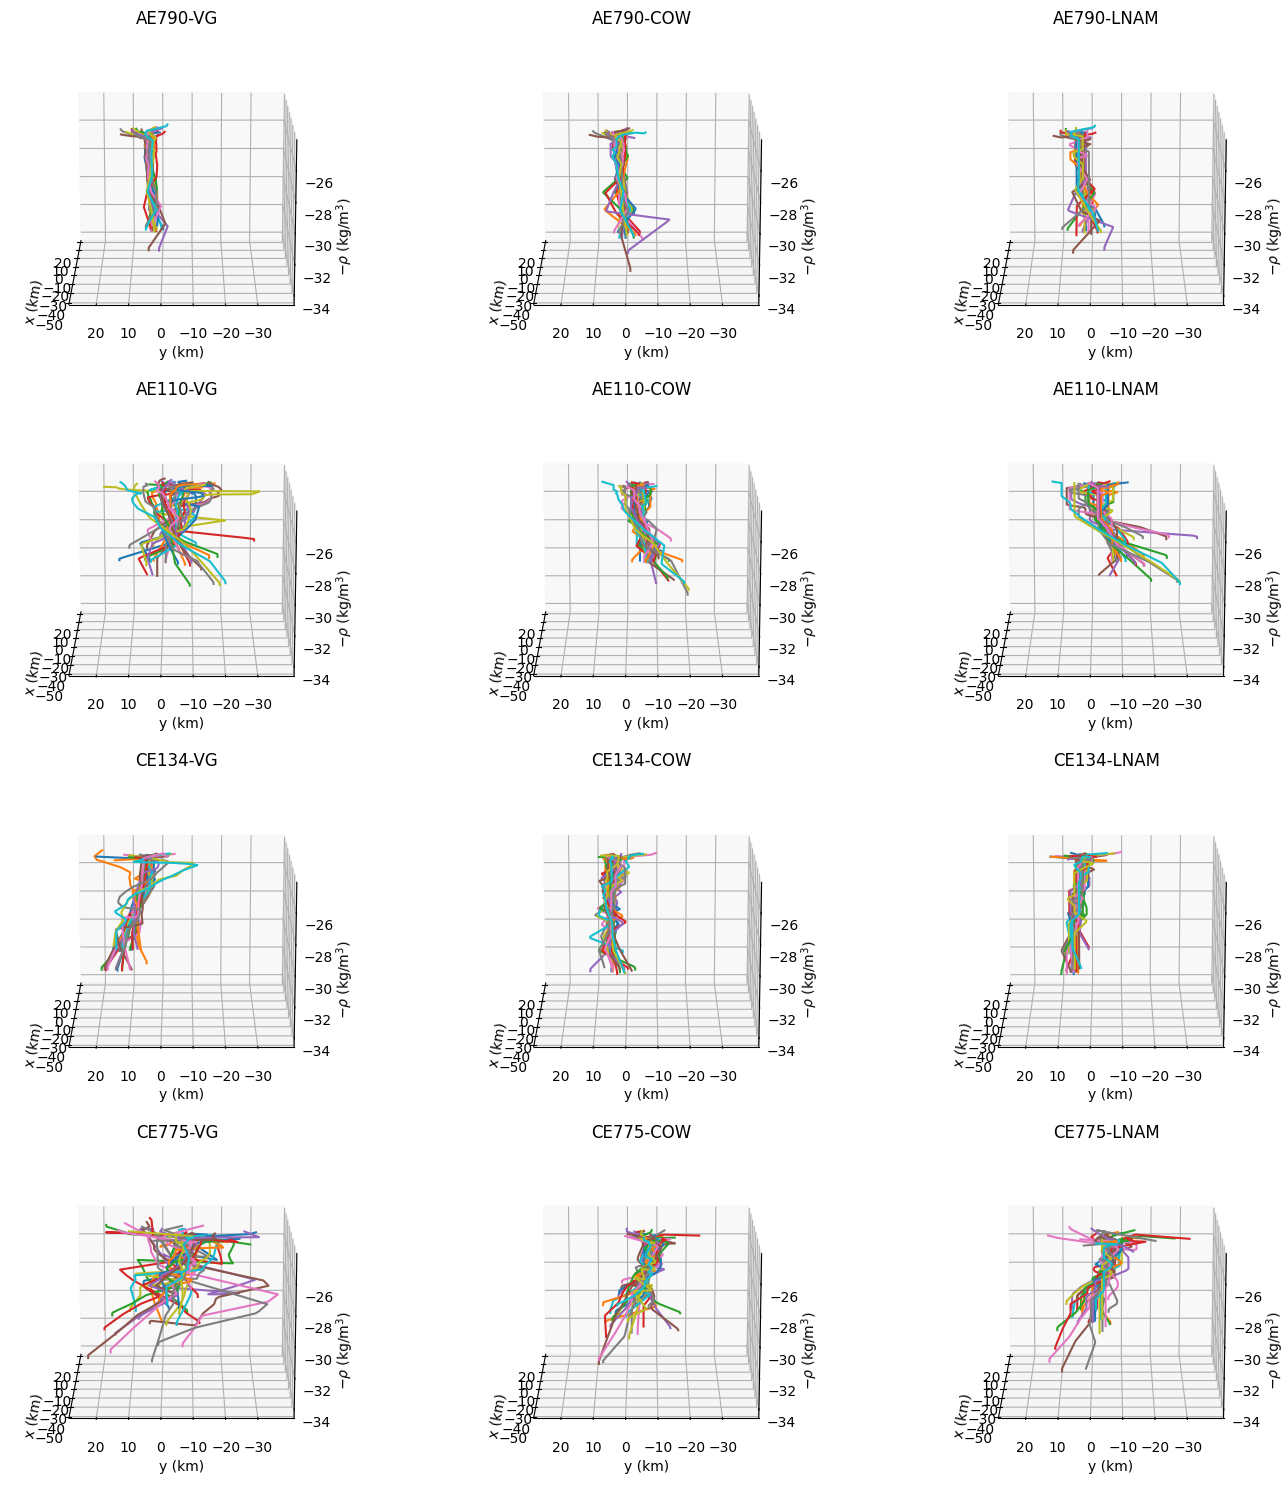

In [11]:
from matplotlib.ticker import FixedLocator

fig, axs = plt.subplots(4, 3, subplot_kw={'projection': '3d'}, figsize=(15,15))

for r, eddy in enumerate(the_frontier_eddies):

    for c, method in enumerate(methods):

        for t in range(30):
            theta = best_rho_shift_dic[eddy][method].loc[t]['theta']
            i = best_rho_shift_dic[eddy][method].loc[t]['i']
            j = best_rho_shift_dic[eddy][method].loc[t]['j']

            x = rho_data_dic[eddy][method]['x'+str(t)] / 1000
            y = rho_data_dic[eddy][method]['y'+str(t)] / 1000
            z = -rho_data_dic[eddy][method].index

            points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
            x_shifted = points_rotated[:, 0] + i
            y_shifted = points_rotated[:, 1] + j

            axs[r, c].plot(x_shifted, y_shifted, z)
            axs[r, c].view_init(15, 180)
            axs[r, c].set_title('AE'+str(extract_number(eddy))+'-'+ method if r < 2 else 'CE'+str(extract_number(eddy))+'-'+ method)
            axs[r, c].set_xlabel('x (km)')
            axs[r, c].set_ylabel('y (km)')
            axs[r, c].set_zlabel(r'$-\rho$ (kg/m$^3$)')

            # z_min, z_max = depth_data_dic[eddy][method].index.min(), depth_data_dic[eddy][method].index.max()
            # axs[r, c].set_zlim(z_max, z_min)

xmax, xmin, ymin, ymax, zmin, zmax = 0, 0, 0, 0, -29, -29
for ax in axs.flat:
    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()
    z1, z2 = ax.get_zlim()
    xmax = max(xmax, x2)
    xmin = min(xmin, x1)
    ymax = max(ymax, y2)
    ymin = min(ymin, y1)
    zmin = min(zmin, z1)
    zmax = max(zmax, z2)

xmax_3Dden, xmin_3Dden, ymin_3Dden, ymax_3Dden, zmin_3Dden, zmax_3Dden = xmax, xmin, ymin, ymax, zmin, zmax

for ax in axs.flat:
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)

    # zticks = ax.get_zticks()
    # ztick_labels = [str(abs(int(tick))) for tick in zticks]
    # ax.zaxis.set_major_locator(FixedLocator(zticks))
    # ax.set_zticklabels(ztick_labels)
    
plt.tight_layout()
plt.show()

### Mean Tilt

In [12]:
mean_shifted_depth_df = pd.DataFrame()
for eddy in the_frontier_eddies:
    for method in methods:
        
        optimal_depth_df = depth_data_dic[eddy][method].copy()
        optimal_depth_df = optimal_depth_df.loc[:, ~optimal_depth_df.columns.str.contains('TD')]
        
        best_shift_3D_df = best_depth_shift_dic[eddy][method]
        
        for t in range(30):
        
            theta = best_shift_3D_df.loc[t]['theta']
            i = best_shift_3D_df.loc[t]['i']
            j = best_shift_3D_df.loc[t]['j']
        
            x = optimal_depth_df['x'+str(t)]/1000
            y = optimal_depth_df['y'+str(t)]/1000
        
            points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
            x_shifted = points_rotated[:, 0] + i
            y_shifted = points_rotated[:, 1] + j
        
            optimal_depth_df['x'+str(t)] = x_shifted
            optimal_depth_df['y'+str(t)] = y_shifted
        
        threshold = 25 #/30
        x_3D_mean = optimal_depth_df.filter(like='x').apply(
            lambda row: row.mean() if row.count() >= threshold else np.nan, axis=1
        )
        y_3D_mean = optimal_depth_df.filter(like='y').apply(
            lambda row: row.mean() if row.count() >= threshold else np.nan, axis=1
        )                                                     
        
        TD_3D_mean = np.hypot(x_3D_mean - x_3D_mean.iloc[0], y_3D_mean - y_3D_mean.iloc[0])

        new_data = {
            eddy + '-' + method + '-x': x_3D_mean,
            eddy + '-' + method + '-y': y_3D_mean,
            eddy + '-' + method + '-TD': TD_3D_mean
        }

        mean_shifted_depth_df = mean_shifted_depth_df.join(pd.DataFrame(new_data), how='outer')


In [13]:
mean_shifted_depth_df

,Eddy790-VG-x,Eddy790-VG-y,Eddy790-VG-TD,Eddy790-COW-x,Eddy790-COW-y,Eddy790-COW-TD,Eddy790-LNAM-x,Eddy790-LNAM-y,Eddy790-LNAM-TD,Eddy110-VG-x,...,Eddy134-LNAM-TD,Eddy775-VG-x,Eddy775-VG-y,Eddy775-VG-TD,Eddy775-COW-x,Eddy775-COW-y,Eddy775-COW-TD,Eddy775-LNAM-x,Eddy775-LNAM-y,Eddy775-LNAM-TD
Depth,,,,,,,,,,,,,,,,,,,,,
-1500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1470.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-40.0,-4.690837,4.506704,1.271142,-5.802430,2.769623,0.915007,-7.011718,3.642126,1.637534,-0.686367,...,2.491348,-5.931222,-6.358127,2.508814,-10.048536,-6.781147,2.860740,-15.114867,-5.860311,0.972139
-30.0,-4.674985,4.567412,1.219375,-5.718730,2.764271,0.850857,-6.832757,4.007094,1.257394,-0.927640,...,1.973840,-5.747452,-6.730119,2.551277,-9.569988,-6.278057,2.260005,-15.083775,-5.130768,0.447577
-20.0,-4.721285,4.771688,1.138393,-5.657877,3.078999,0.643376,-6.775499,3.968505,1.240199,-1.136834,...,1.631632,-4.415051,-5.211656,0.709945,-8.616177,-6.073576,1.284524,-14.543501,-5.094206,0.142975


In [14]:
mean_shifted_rho_df = pd.DataFrame()
for eddy in the_frontier_eddies:
    for method in methods:
        
        optimal_rho_df = rho_data_dic[eddy][method].copy()
        optimal_rho_df = optimal_rho_df.loc[:, ~optimal_rho_df.columns.str.contains('TD')]
        
        best_shift_3D_df = best_rho_shift_dic[eddy][method]
        
        for t in range(30):
        
            theta = best_shift_3D_df.loc[t]['theta']
            i = best_shift_3D_df.loc[t]['i']
            j = best_shift_3D_df.loc[t]['j']
        
            x = optimal_rho_df['x'+str(t)]/1000
            y = optimal_rho_df['y'+str(t)]/1000
        
            points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
            x_shifted = points_rotated[:, 0] + i
            y_shifted = points_rotated[:, 1] + j
        
            optimal_rho_df['x'+str(t)] = x_shifted
            optimal_rho_df['y'+str(t)] = y_shifted

        x_3D_mean = optimal_rho_df.filter(like='x').mean(axis=1)
        y_3D_mean = optimal_rho_df.filter(like='y').mean(axis=1)
        # threshold = 5 #/30
        # x_3D_mean = optimal_rho_df.filter(like='x').apply(
        #     lambda row: row.mean() if row.count() >= threshold else np.nan, axis=1
        # )
        # y_3D_mean = optimal_rho_df.filter(like='y').apply(
        #     lambda row: row.mean() if row.count() >= threshold else np.nan, axis=1
        # )     
        TD_3D_mean = np.hypot(x_3D_mean - x_3D_mean.iloc[0], y_3D_mean - y_3D_mean.iloc[0])

        new_data = {
            eddy + '-' + method + '-x': x_3D_mean,
            eddy + '-' + method + '-y': y_3D_mean,
            eddy + '-' + method + '-TD': TD_3D_mean
        }

        mean_shifted_rho_df = mean_shifted_rho_df.join(pd.DataFrame(new_data), how='outer')


In [15]:
mean_shifted_rho_df

,Eddy790-VG-x,Eddy790-VG-y,Eddy790-VG-TD,Eddy790-COW-x,Eddy790-COW-y,Eddy790-COW-TD,Eddy790-LNAM-x,Eddy790-LNAM-y,Eddy790-LNAM-TD,Eddy110-VG-x,...,Eddy134-LNAM-TD,Eddy775-VG-x,Eddy775-VG-y,Eddy775-VG-TD,Eddy775-COW-x,Eddy775-COW-y,Eddy775-COW-TD,Eddy775-LNAM-x,Eddy775-LNAM-y,Eddy775-LNAM-TD
rho,,,,,,,,,,,,,,,,,,,,,
24.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.667584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.681905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.071287,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.812654,...,5.098444,3.751912,18.496322,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
24.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.664874,...,4.938412,-5.595932,-1.058068,21.673863,-4.590773,-4.602209,0.0,-5.756988,-4.917424,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34.0,5.616779,2.465620,8.673448,-7.096421,-1.366634,4.828518,5.028905,0.407755,10.377215,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34.1,5.895841,2.692829,8.877590,-7.371008,-1.075116,4.750997,5.185636,0.721482,10.386999,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34.2,6.174903,2.920038,9.091397,-7.645595,-0.783598,4.706392,5.342366,1.035208,10.408597,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


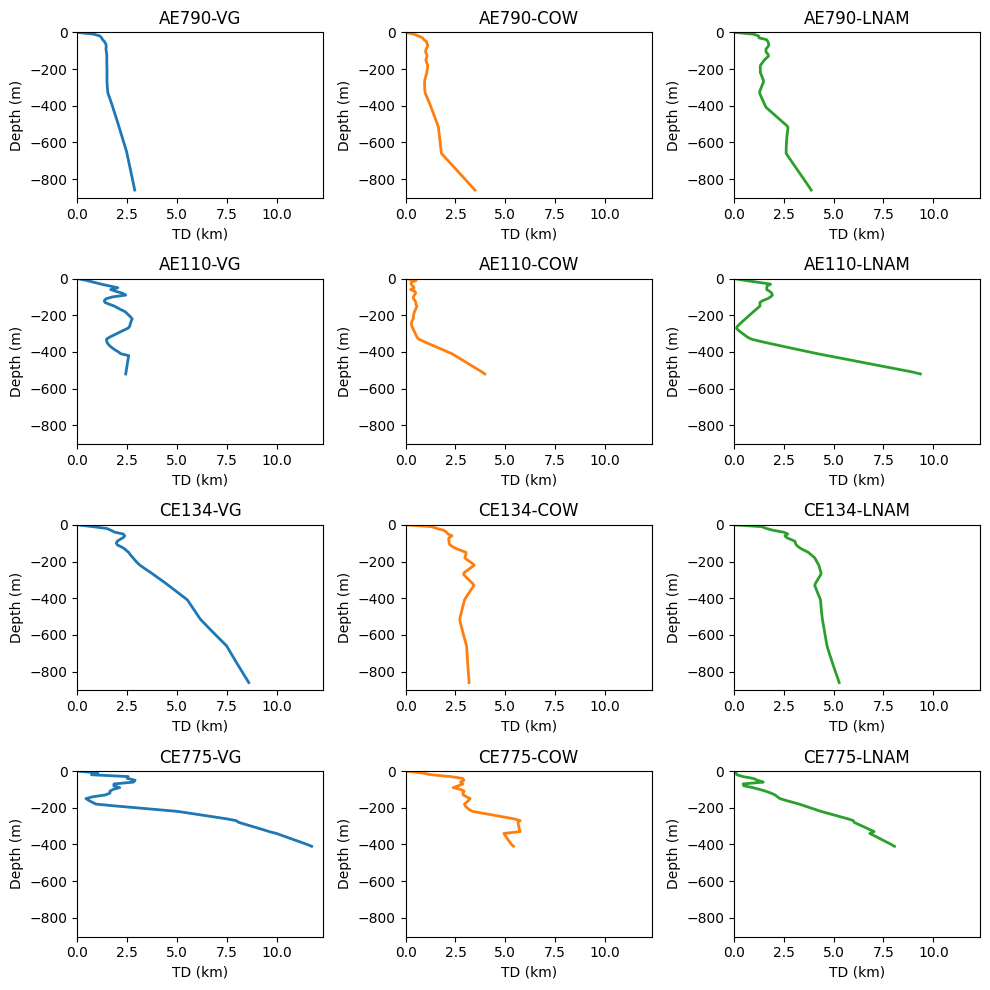

In [16]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))
colors = plt.get_cmap('tab10')
for r, eddy in enumerate(the_frontier_eddies):
    for c, method in enumerate(methods):

        axs[r, c].plot(mean_shifted_depth_df[eddy+'-'+method+'-'+'TD'], mean_shifted_depth_df.index, color=colors(c), linewidth=2)
        axs[r, c].set_title('AE'+str(extract_number(eddy))+'-'+ method if r < 2 else 'CE'+str(extract_number(eddy))+'-'+ method)
        axs[r, c].set_xlabel('TD (km)')
        axs[r, c].set_ylabel('Depth (m)')


xmax_dep, ymin_dep = 0, 0
for ax in axs.flat:
    xmax_dep = max(xmax_dep, ax.get_xlim()[1])
    ymin_dep = min(ymin_dep, ax.get_ylim()[0])

for ax in axs.flat:
    ax.set_ylim(ymin_dep, 0)
    ax.set_xlim(0, xmax_dep)

plt.tight_layout()
plt.show()

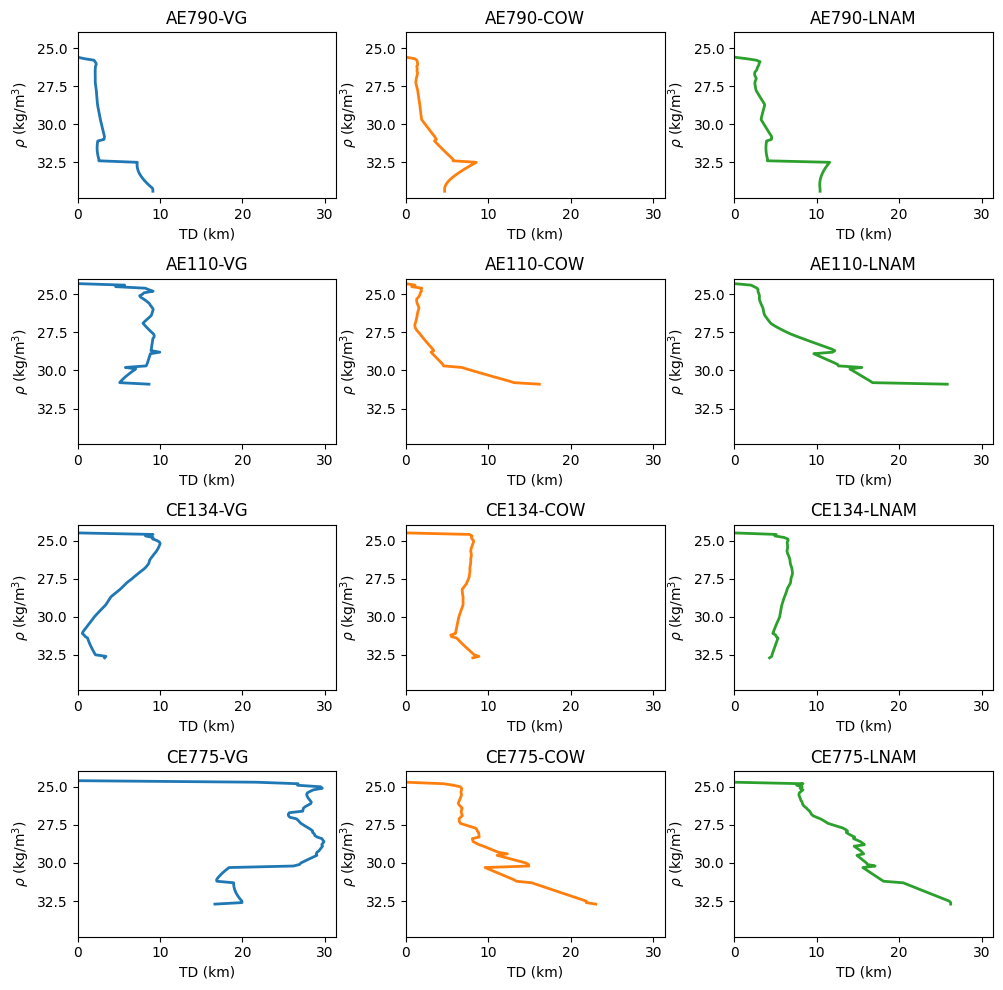

In [17]:
fig, axs = plt.subplots(4, 3, figsize=(10,10))
colors = plt.get_cmap('tab10')
for r, eddy in enumerate(the_frontier_eddies):
    for c, method in enumerate(methods):

        axs[r, c].plot(mean_shifted_rho_df[eddy+'-'+method+'-'+'TD'], mean_shifted_rho_df.index, color=colors(c), linewidth=2)
        axs[r, c].set_title('AE'+str(extract_number(eddy))+'-'+ method if r < 2 else 'CE'+str(extract_number(eddy))+'-'+ method)
        axs[r, c].set_xlabel('TD (km)')
        axs[r, c].set_ylabel(r'$\rho$ (kg/m$^3$)')


xmax_den, ymin_den, ymax_den = 28, 28, -np.inf
for ax in axs.flat:
    xmax_den = max(xmax_den, ax.get_xlim()[1])
    ymin_den = min(ymin_den, ax.get_ylim()[0])
    ymax_den = max(ymax_den, ax.get_ylim()[1])

for ax in axs.flat:
    ax.set_ylim(ymin_den, ymax_den)
    ax.set_xlim(0, xmax_den)
    ax.invert_yaxis()
    
plt.tight_layout()
plt.show()

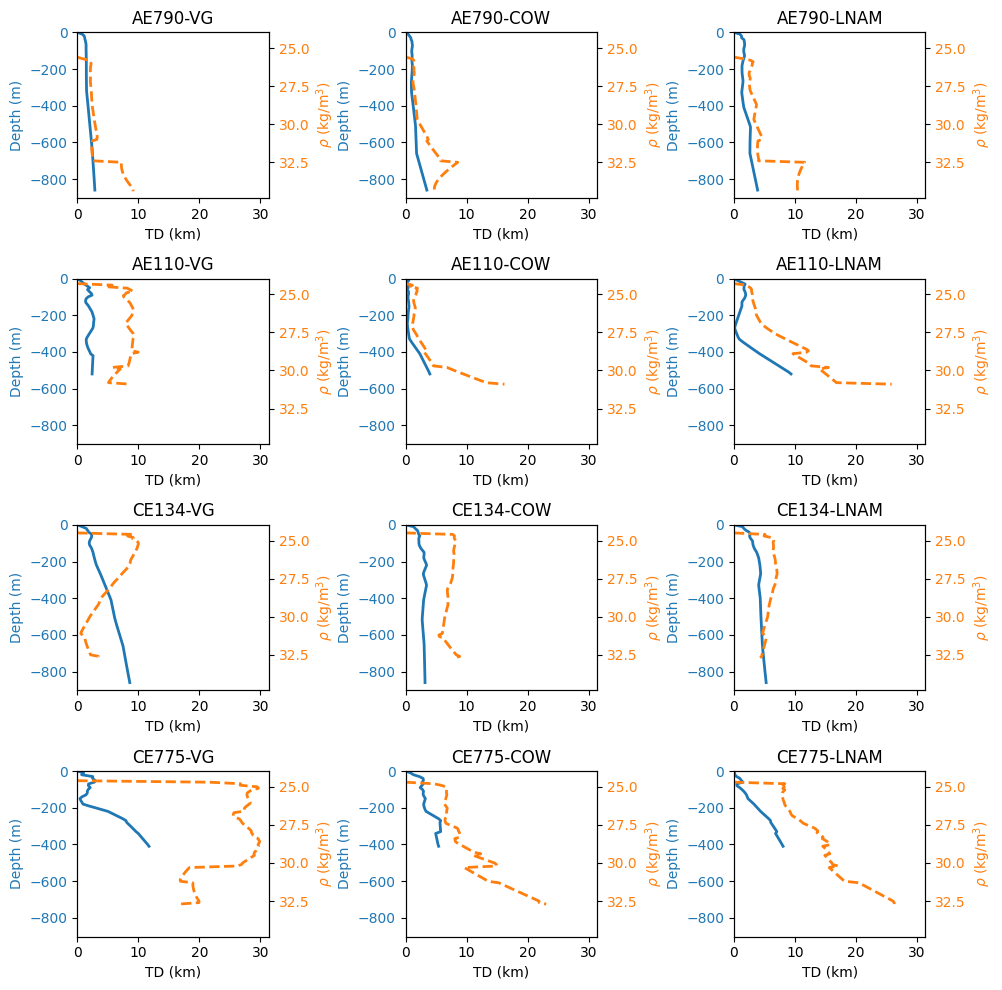

In [18]:
fig, axs = plt.subplots(4, 3, figsize=(10, 10))
colors = plt.get_cmap('tab10')

for r, eddy in enumerate(the_frontier_eddies):
    for c, method in enumerate(methods):
        ax1 = axs[r, c]  # Primary axis
        ax2 = ax1.twinx()  # Secondary axis (twin y-axis)

        # Plot TD vs Depth on primary axis
        ax1.plot(mean_shifted_depth_df[eddy+'-'+method+'-'+'TD'], mean_shifted_depth_df.index, 
                 color=colors(0), linewidth=2, zorder=1)
        ax1.set_ylabel('Depth (m)', color=colors(0))
        ax1.set_ylim(ymin_dep, 0)
        ax1.tick_params(axis='y', labelcolor=colors(0))

        # Plot TD vs Rho on secondary axis
        ax2.plot(mean_shifted_rho_df[eddy+'-'+method+'-'+'TD'], mean_shifted_rho_df.index, 
                 color=colors(1), linewidth=2, linestyle='--', zorder=0)
        ax2.set_ylabel(r'$\rho$ (kg/m$^3$)', color=colors(1))
        ax2.tick_params(axis='y', labelcolor=colors(1))
        
        # Flip only the density y-axis
        ax2.set_ylim(ymin_den, ymax_den)
        ax2.invert_yaxis()

        # Shared x-axis
        ax1.set_xlabel('TD (km)')
        ax1.set_title('AE'+str(extract_number(eddy))+'-'+ method if r < 2 else 'CE'+str(extract_number(eddy))+'-'+ method)

xmax = 0
for ax in axs.flat:
    xmax = max(xmax, ax.get_xlim()[1])

xmax_TD = xmax

for ax in axs.flat:
    ax.set_xlim(0, xmax)

plt.tight_layout()
plt.show()


In [19]:
def combined_eddy_plot(eddy):
    
    fig = plt.figure(figsize=(10, 10))
    colors = plt.get_cmap('tab10')
    
    # Create a grid of subplots, with the first two columns being 3D plots
    axs = [
        [
            fig.add_subplot(3, 3, i * 3 + j + 1, projection='3d' if j < 2 else None)
            for j in range(3)
        ]
        for i in range(3)
    ]
    
    for m, method in enumerate(methods):
    
        # 3D Plot1
        for t in range(30):
            theta = best_depth_shift_dic[eddy][method].loc[t]['theta']
            i = best_depth_shift_dic[eddy][method].loc[t]['i']
            j = best_depth_shift_dic[eddy][method].loc[t]['j']
    
            x = depth_data_dic[eddy][method]['x' + str(t)] / 1000
            y = depth_data_dic[eddy][method]['y' + str(t)] / 1000
            z = depth_data_dic[eddy][method].index
    
            points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
            x_shifted = points_rotated[:, 0] + i
            y_shifted = points_rotated[:, 1] + j
    
            axs[m][0].plot(x_shifted, y_shifted, z)
            axs[m][0].view_init(15, 180)
            axs[m][0].set_title('AE' + str(extract_number(eddy)) + '-' + method if the_frontier_eddies.index(eddy) < 2 else 'CE' + str(extract_number(eddy)) + '-' + method, color=colors(0))
            axs[m][0].set_xlabel('x (km)')
            axs[m][0].set_ylabel('y (km)')
            axs[m][0].set_zlabel('Depth (m)')
    
        # 3D Plot2
        for t in range(30):
            theta = best_rho_shift_dic[eddy][method].loc[t]['theta']
            i = best_rho_shift_dic[eddy][method].loc[t]['i']
            j = best_rho_shift_dic[eddy][method].loc[t]['j']
    
            x = rho_data_dic[eddy][method]['x' + str(t)] / 1000
            y = rho_data_dic[eddy][method]['y' + str(t)] / 1000
            z = -rho_data_dic[eddy][method].index
    
            points_rotated = rotate_y_xy(np.column_stack((x, y)), theta)
            x_shifted = points_rotated[:, 0] + i
            y_shifted = points_rotated[:, 1] + j
    
            axs[m][1].plot(x_shifted, y_shifted, z)
            axs[m][1].view_init(15, 180)
            axs[m][1].set_title('AE' + str(extract_number(eddy)) + '-' + method if the_frontier_eddies.index(eddy) < 2 else 'CE' + str(extract_number(eddy)) + '-' + method, color=colors(1))
            axs[m][1].set_xlabel('x (km)')
            axs[m][1].set_ylabel('y (km)')
            axs[m][1].set_zlabel(r'$-\rho$ (kg/m$^3$)')
    
        # Regular 2D Plot
        ax1 = axs[m][2]
        ax2 = ax1.twinx()
    
        ax1.plot(mean_shifted_depth_df[eddy + '-' + method + '-' + 'TD'], mean_shifted_depth_df.index, 
                 color=colors(0), linewidth=2, zorder=1)
        ax1.set_ylabel('Depth (m)', color=colors(0))
        ax1.set_ylim(ymin_dep, 0)
        ax1.tick_params(axis='y', labelcolor=colors(0))
    
        ax2.plot(mean_shifted_rho_df[eddy + '-' + method + '-' + 'TD'], mean_shifted_rho_df.index, 
                 color=colors(1), linewidth=2, linestyle='--', zorder=0)
        ax2.set_ylabel(r'$\rho$ (kg/m$^3$)', color=colors(1))
        ax2.tick_params(axis='y', labelcolor=colors(1))
        ax2.set_ylim(ymin_den, ymax_den)
        ax2.invert_yaxis()
    
        ax1.set_xlabel('TD (km)')
        ax1.set_title('AE' + str(extract_number(eddy)) + '-' + method if the_frontier_eddies.index(eddy) < 2 else 'CE' + str(extract_number(eddy)) + '-' + method)
    
    for m in range(3):
        axs[m][0].set_xlim(xmin_3Ddep, xmax_3Ddep)
        axs[m][0].set_ylim(ymin_3Ddep, ymax_3Ddep)

        axs[m][1].set_xlim(xmin_3Dden, xmax_3Dden)
        axs[m][1].set_ylim(ymin_3Dden, ymax_3Dden)

        axs[m][2].set_xlim(0, xmax_TD)
    
    plt.tight_layout()
    plt.show()


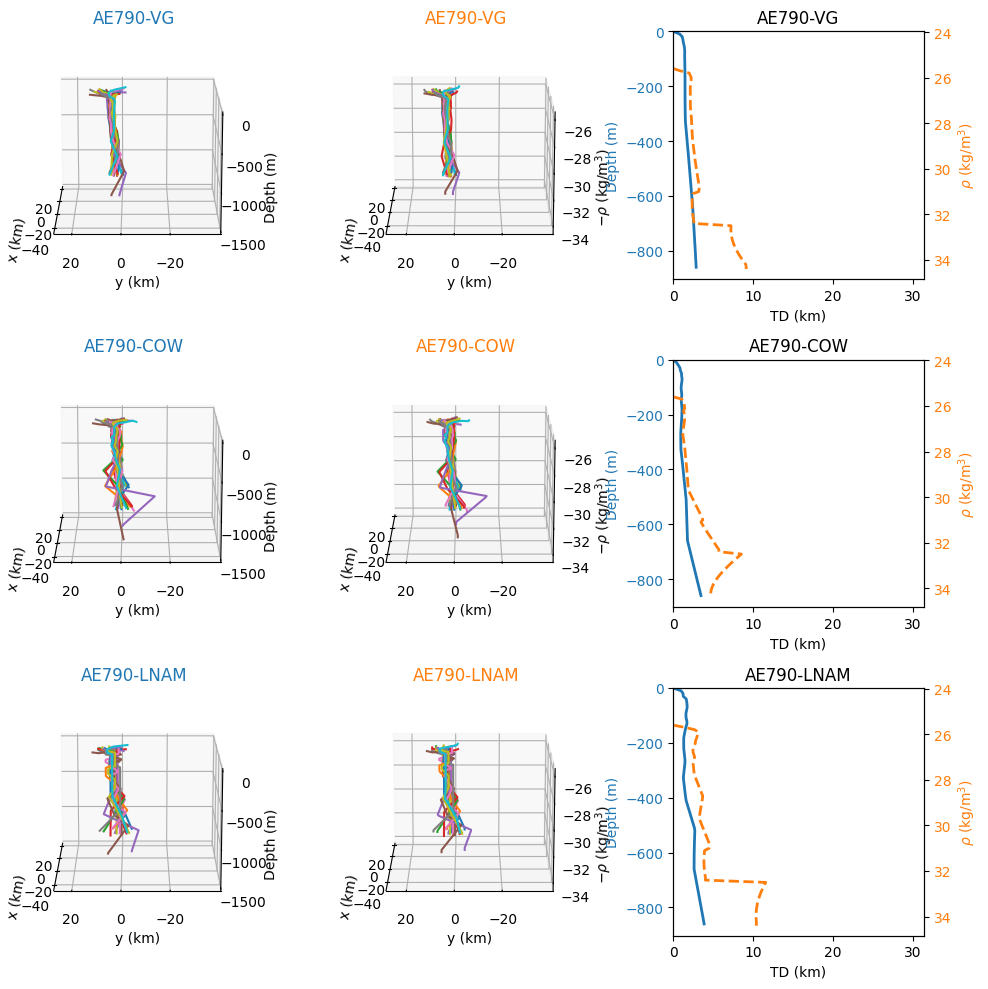

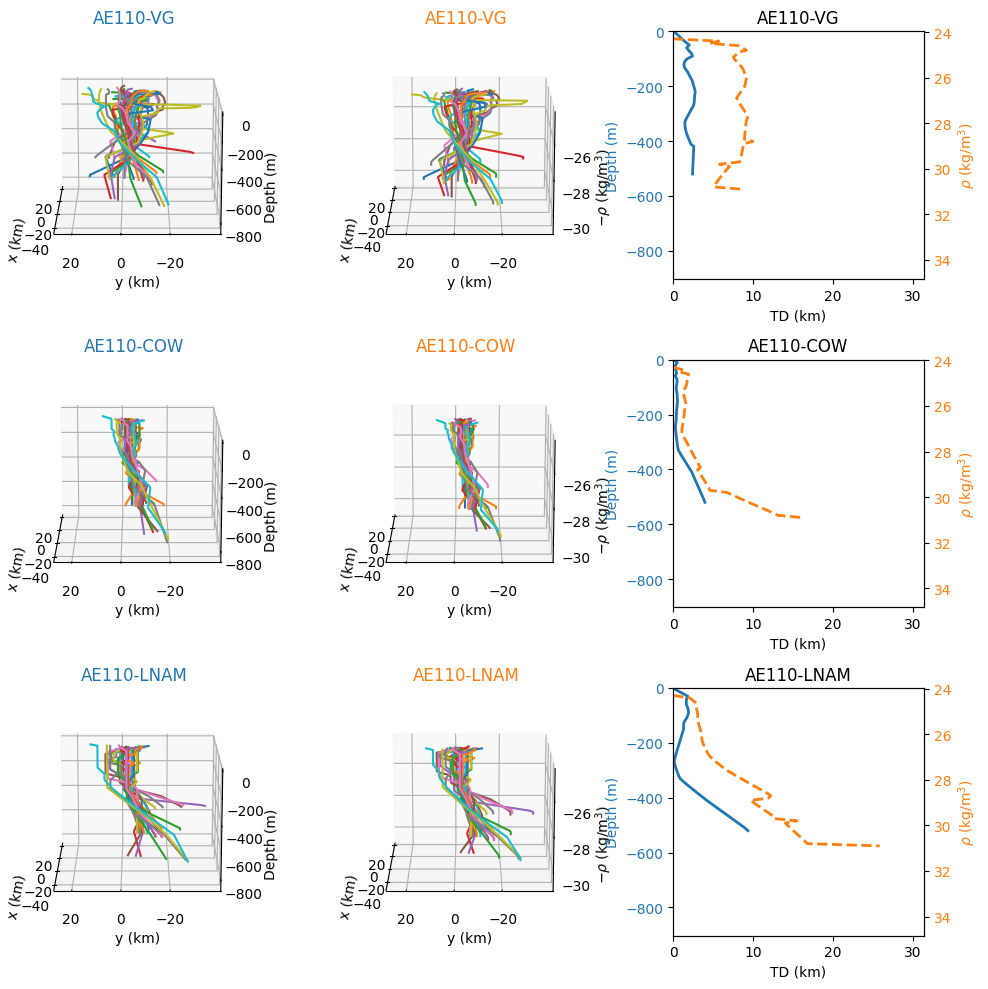

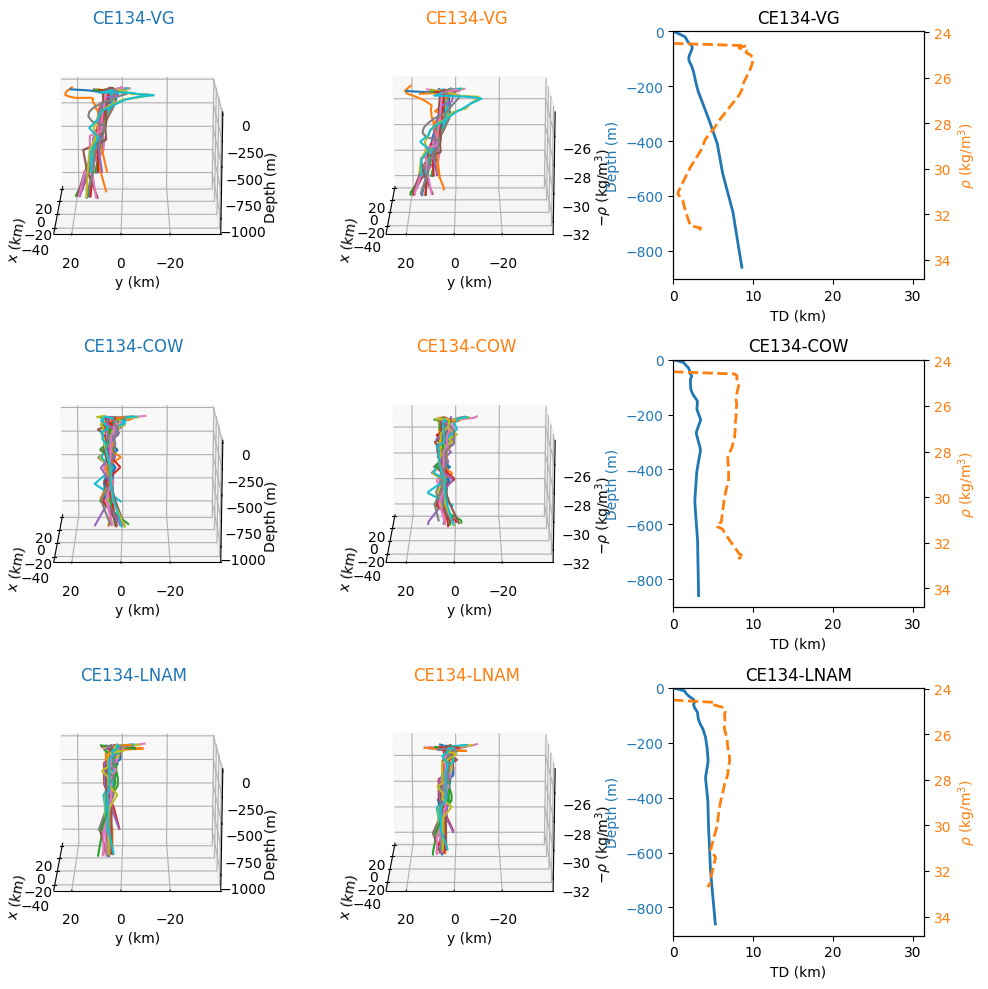

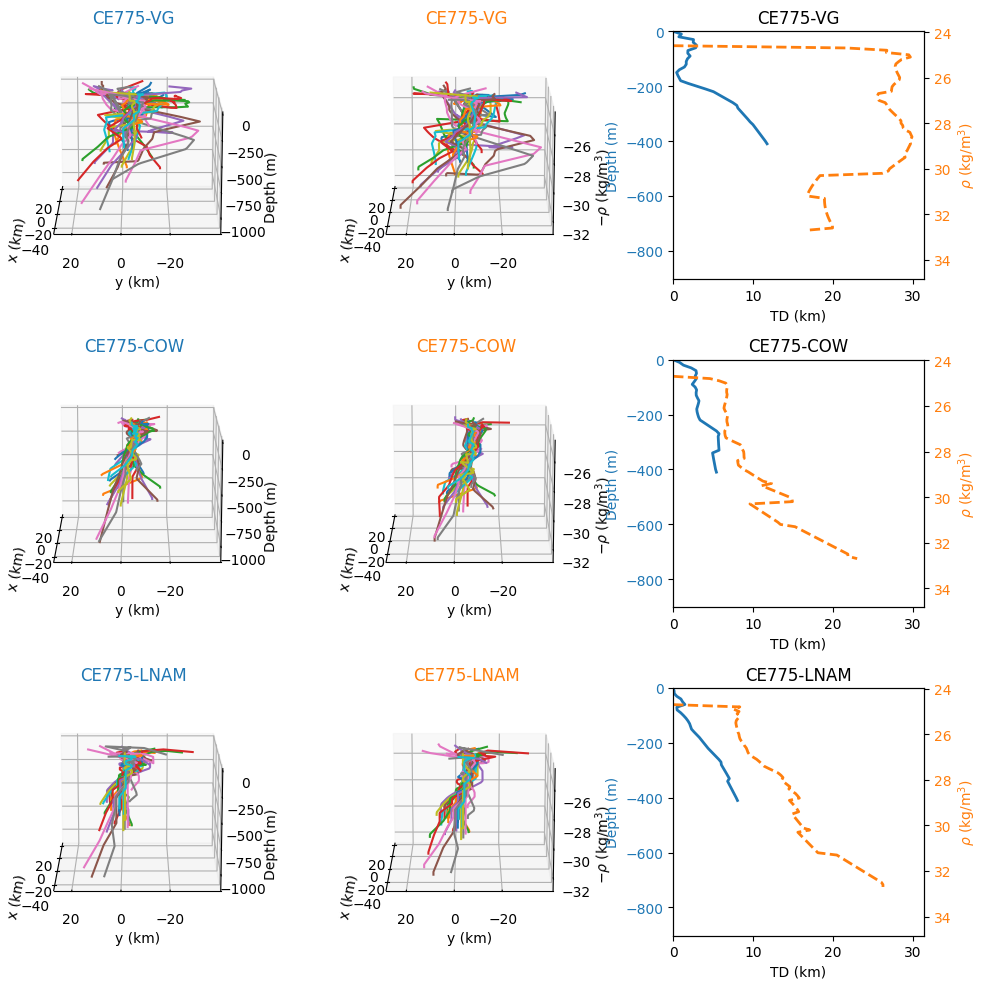

In [20]:
for eddy in the_frontier_eddies:
    combined_eddy_plot(eddy)
